In [1]:
import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
import diffrax as dfx

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.shapes import Shape
from pde_opt.numerics.equations.cahn_hilliard import CahnHilliard2DPeriodic
from pde_opt.numerics.solvers import SemiImplicitFourierSpectral

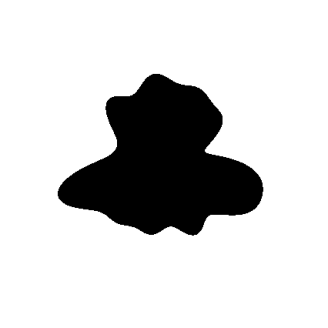

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Create the parametric curve
theta = np.linspace(0, 2*np.pi, 400)
r = 1 + 0.2*np.sin(3*theta) + 0.15*np.sin(5*theta) + 0.1*np.sin(7*theta) + 0.05*np.cos(11*theta)
x = r * np.cos(theta)
y = r * np.sin(theta)

# Create a grid
grid_size = 400
x_grid = np.linspace(-2, 2, grid_size)
y_grid = np.linspace(-2, 2, grid_size)
X, Y = np.meshgrid(x_grid, y_grid)

# Create path for matplotlib to determine points inside/outside
from matplotlib.path import Path
path = Path(np.column_stack([x, y]))
points = np.column_stack([X.flatten(), Y.flatten()])

# Create mask of points inside the curve (1 inside, 0 outside)
mask = path.contains_points(points).reshape(grid_size, grid_size)

# Visualize the result
plt.figure(figsize=(4,4))
plt.imshow(mask, extent=[-2, 2, -2, 2], cmap='binary')
plt.axis('off')
plt.show()


In [3]:
shape = Shape(
    binary=jnp.array(mask),
    dx=(1.0, 1.0),
    smooth_epsilon=25.0,
    smooth_curvature=0.008,
    smooth_dt=0.01,
    smooth_tf=100.0,
)

ERROR:2025-10-01 14:36:25,855:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/aecohen/.conda/envs/pde-opt-env/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/aecohen/.conda/envs/pde-opt-env/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/aecohen/.conda/envs/pde-opt-env/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE


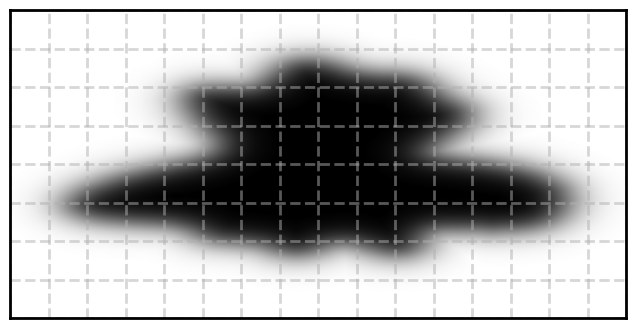

In [14]:
plt.figure(figsize=(8,4))
plt.imshow(shape.smooth[30:360,30:360], extent=[-4, 4, -2, 2], cmap='binary')
plt.grid(True, linestyle='--', alpha=0.5, linewidth=2.0)
plt.axis('on')  # Keep axis on to show grid
plt.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)  # Remove tick labels
# plt.gca().set_aspect('equal')
# Set equal grid spacing
plt.gca().set_xticks(np.arange(-4, 4.1, 0.5))
plt.gca().set_yticks(np.arange(-2, 2.1, 0.5))
for spine in plt.gca().spines.values():
    spine.set_linewidth(2.0)
plt.show()

In [5]:
Nx, Ny = 256, 256
Lx = 0.01 * Nx
Ly = 0.01 * Ny
domain = Domain((Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless")

t_start = 0.0
t_final = 0.2
dt = 0.000001

ts_save = jnp.linspace(t_start, t_final, 200)

kappa = 0.002

In [6]:
eq = CahnHilliard2DPeriodic(
    domain,
    kappa,
    lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    lambda c: (1.0 - c) * c,
    derivs="fd"
)

solver = SemiImplicitFourierSpectral(0.5, eq.fourier_symbol, eq.fft, eq.ifft)

In [7]:
key = random.PRNGKey(0)
u0 = 0.5 * jnp.ones((Nx, Ny)) + 0.01 * random.normal(key, (Nx, Ny))

solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    # stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

print(solution.stats)

print(jnp.mean(solution.ys[0]))
print(jnp.mean(solution.ys[-1]))

{'max_steps': 1000000, 'num_accepted_steps': Array(200269, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(200269, dtype=int32, weak_type=True)}
0.4999641
0.49986264


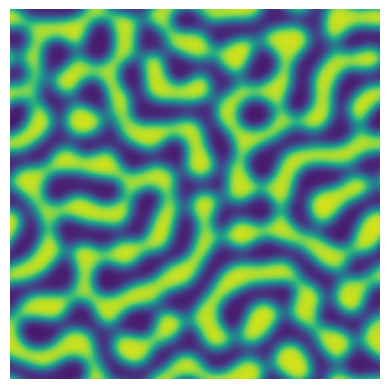

In [8]:
plt.imshow(solution.ys[75], vmin=0.0, vmax=1.0)
plt.axis('off')
plt.gca().set_aspect('equal')
plt.show()

In [9]:
from pde_opt.rl_utils import detect_vortices, density
from pde_opt.numerics.equations.gross_pitaevskii import GPE2DTSControl, hbar, mass_Na23, a0
from pde_opt.numerics.solvers import StrangSplitting
from pde_opt.numerics.utils.initialization_utils import initialize_Psi
from scipy.ndimage import zoom

import gymnasium as gym

In [10]:
# Get variables with dimensions
atoms = 5e5 # number of atoms
omega = 2*jnp.pi*10 # 1/s (angular frequency of the trap in the x and y directions)
omega_z = jnp.sqrt(8)*omega # 1/s (angular frequency of the trap in the z direction)
epsilon = 0.0 # eccentricity of the trap
a_s = 100*a0 # s-wave scattering length

# Length of the x and y axes in meters
Lx = 150e-6 #meters
Ly = 150e-6 #meters

x_s = jnp.sqrt(hbar/(mass_Na23*omega)) # length scale
t_s = 1/omega # time scale

# Get dimensionless variables
Lx_ = Lx/x_s
Ly_ = Ly/x_s

# Get k
k = 4*jnp.pi*a_s*atoms*jnp.sqrt((mass_Na23*omega_z)/(2*jnp.pi*hbar)) # dimensionless coupling constant

N = 256 # number of grid points
domain_ = Domain((N,N,), ((-Lx_/2, Lx_/2), (-Ly_/2, Ly_/2),), "dimensionless")

Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi0*x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_))*domain_.dx[0]**2)

eq = GPE2DTSControl(domain_, k, epsilon, lambda a,b,c: 0.0, trap_factor=1.0)
solver = StrangSplitting(eq.A_term, eq.domain.dx[0], eq.fft, eq.ifft, -1j)

solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.B_terms(y, t))),
    solver,
    t0=0.0,
    t1=0.05 / t_s,
    dt0=1e-5 / t_s,
    y0=jnp.stack([Psi0_.real, Psi0_.imag], axis=-1),
    saveat=diffrax.SaveAt(t1=True),
    max_steps=1000000,
)

ground_state = solution.ys[-1]

In [11]:
end_time = 1.0 / t_s
step_dt = 0.01 / t_s
numeric_dt = 1e-5 / t_s

def reset_function(domain):
    if ground_state.shape[:-1] != domain.points:
        # Reshape ground_state to match domain points
        zoom_factors = (domain.points[0] / ground_state.shape[0], 
                       domain.points[1] / ground_state.shape[1])
        resized = zoom(ground_state, zoom_factors, order=1)
        return resized
    return ground_state

reset_control_value = (0.0, 0.0)

def state_to_observation(state):
    _density = density(state[...,0] + 1j*state[...,1])
    return (np.clip(np.array(_density), 0, 0.01) * 100 * 255).astype(np.uint8)[None]

# reward function
def reward_function(state):
    psi = state[...,0] + 1j*state[...,1]
    vorts = detect_vortices(psi, amp_thresh=0.00005, tol=0.5)
    return vorts["num_vortices"]

continuous_action_space_config = {
    "type": "continuous",
    "shape": (2,),
    "low": float(-1e-5 / x_s),
    "high": float(1e-5 / x_s),
}

discrete_action_space_config = {
    "type": "discrete",
    "num_actions": 5,
    "action_mapping": {
        0: (0.0, 0.0), # no change
        1: (-0.5e-5 / x_s, 0.0), # move left
        2: (0.5e-5 / x_s, 0.0), # move right
        3: (0.0, -0.5e-5 / x_s), # move down
        4: (0.0, 0.5e-5 / x_s), # move up
    }
}

def update_control_value(action, old_control_value):
    return (old_control_value[0] + action[0], old_control_value[1] + action[1])

def update_control_parameter(old_control_value, new_control_value):
    path_fn = lambda t: (
        old_control_value[0] + (new_control_value[0] - old_control_value[0]) * t / step_dt,
        old_control_value[1] + (new_control_value[1] - old_control_value[1]) * t / step_dt,
    )
    def light(t, xs, ys):
        A = 30.0
        sigma = 2e-6 / x_s
        xi, yi = path_fn(t)
        return A*jnp.exp(-((xs-xi)**2 + (ys-yi)**2)/(2.0*sigma**2))
    return light

static_equation_parameters = {
    "k": k,
    "e": epsilon,
    "trap_factor": 1.0,
}

solver_parameters = {
    "time_scale": (1.0 - 1j*0.01),
}

params = {
    "equation_type": GPE2DTSControl,
    "domain": domain_,
    "solver_type": StrangSplitting,
    "end_time": end_time,
    "step_dt": step_dt,
    "numeric_dt": numeric_dt,
    "state_to_observation_func": state_to_observation,
    "reward_function": reward_function,
    "reset_func": reset_function,
    "reset_control_value": reset_control_value,
    "update_control_value": update_control_value,
    "update_control_parameter": update_control_parameter,
    "action_space_config": continuous_action_space_config,
    "static_equation_parameters": static_equation_parameters,
    "control_equation_parameter_name": "lights",
    "solver_parameters": solver_parameters
}

env = gym.make('PDEEnv-v0', **params)

In [48]:
env.reset()

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 256, 256), dtype=uint8),
 {})

In [122]:
N = 20
actions = []
positions = [(0,0)]  # Start at origin
current_pos = [0,0]

observations = []

observations.append(env.reset()[0])

for i in range(N):
    action = env.action_space.sample()
    # action = jnp.array([0.2,0.2*(-1)**i])
    actions.append(action)
    observation, reward, terminated, truncated, info = env.step(action)
    observations.append(observation)
    
    # Update current position by adding the action offset
    current_pos[0] += action[1]
    current_pos[1] -= action[0]
    positions.append((current_pos[0], current_pos[1]))


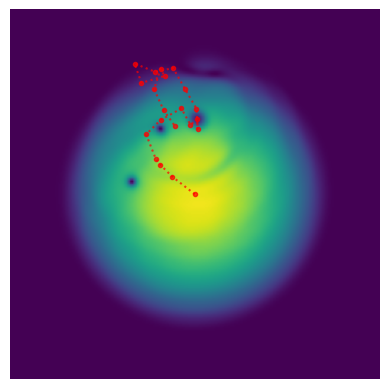

In [123]:
# Plot final observation with trajectory
plt.imshow(observations[8][0], vmin=0, vmax=255, extent=[domain_.box[0][0], domain_.box[0][1], domain_.box[1][0], domain_.box[1][1]])
positions = np.array(positions)
plt.plot(positions[:,0], positions[:,1], 'r:', alpha=0.7)
plt.plot(positions[:,0], positions[:,1], 'r.', alpha=0.7)
plt.axis('off')
plt.gca().set_aspect('equal')
plt.show()